In [2]:
# ## 1. Import libraries and load data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load training dataset
df = pd.read_csv("data/train.csv")

In [3]:
# ## Drop identifier column 'id'
# Removes the 'id' column to avoid leakage / useless features in modeling.

if 'id' in df.columns:
    df = df.drop(columns=['id'])
    print("'id' dropped. New shape:", df.shape)
elif df.index.name == 'id':
    # If 'id' was set as the index, reset and then drop
    df = df.reset_index(drop=True)
    print("'id' was index; reset_index done. New shape:", df.shape)
else:
    print("No 'id' column found (and not used as index).")


'id' dropped. New shape: (188318, 131)


In [4]:
# ## X und y definieren (alle Features außer 'loss')
target = "loss"
assert target in df.columns, "Spalte 'loss' fehlt in df."

y = df[target]                  # Zielvariable
X = df.drop(columns=[target])   # alle übrigen Spalten als Features

print("X shape:", X.shape, "| y shape:", y.shape)


X shape: (188318, 130) | y shape: (188318,)


# Train test split

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [6]:
# ## 5. Zero variance features (learn on X_train, apply to both train/test)

# Identify zero-variance columns on TRAIN only
zero_var = [col for col in X_train.columns if X_train[col].nunique(dropna=False) <= 1]
print("Zero-variance features (from train):", zero_var)

# Drop the same columns from TRAIN (and TEST if available)
X_train = X_train.drop(columns=zero_var, errors="ignore")
if "X_test" in globals():
    X_test = X_test.drop(columns=zero_var, errors="ignore")

print("Shapes -> X_train:", X_train.shape, "| X_test:", X_test.shape if "X_test" in globals() else "n/a")


Zero-variance features (from train): []
Shapes -> X_train: (150654, 130) | X_test: (37664, 130)


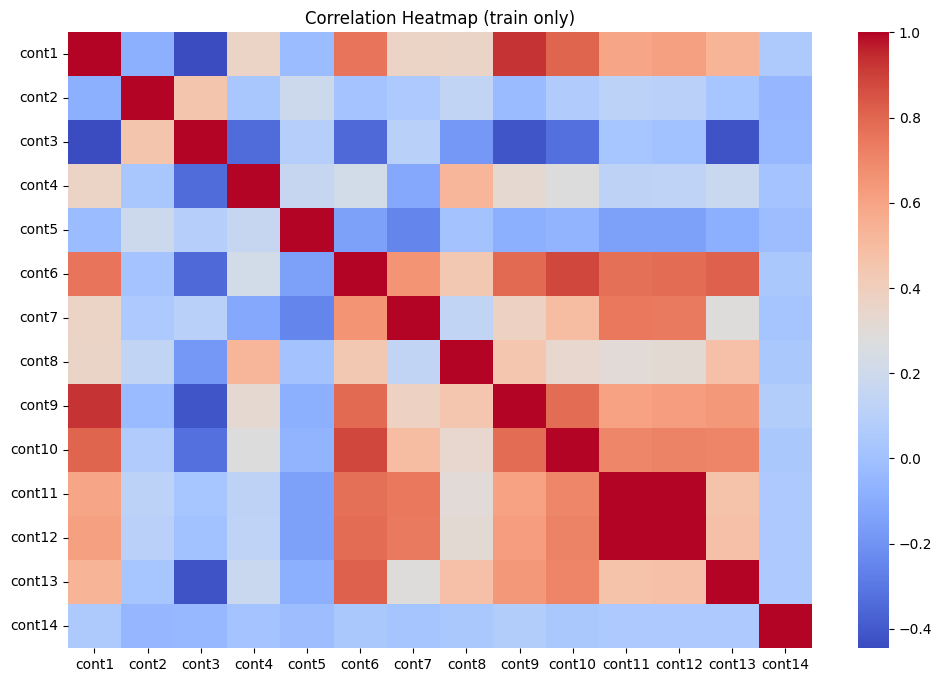

In [7]:
# ## 6. Correlation matrix on X_train (numeric features only)

# Compute correlation on TRAIN numerics only (avoids leakage)
corr = X_train.corr(numeric_only=True)

# Heatmap to visualize correlations
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (train only)")
plt.show()


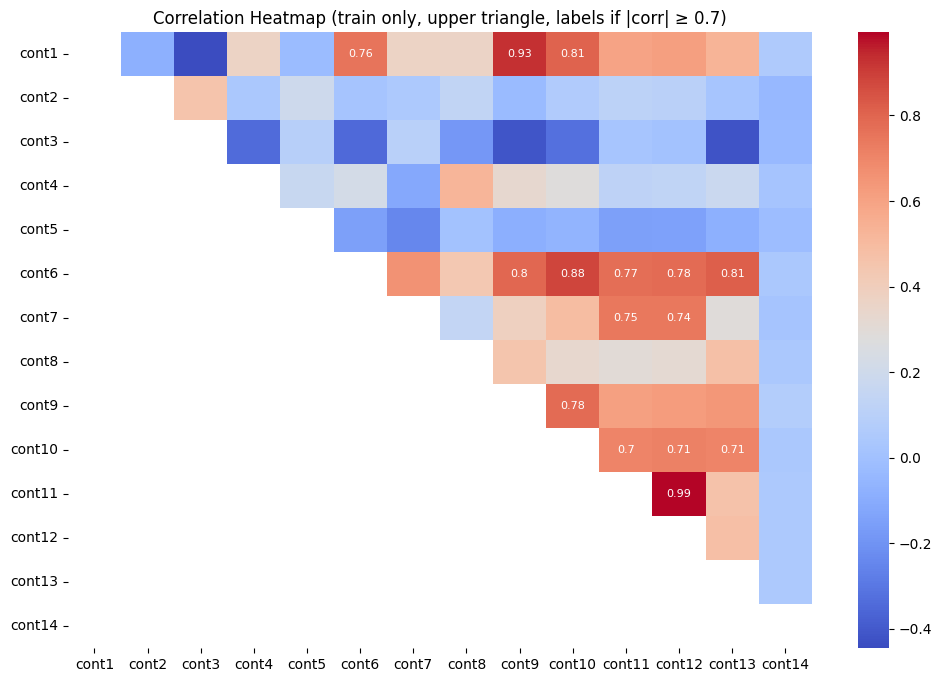

In [8]:
# ## 6b. Correlation heatmap (upper triangle, annotate strong values) on X_train

# Thresholded labels keep the plot readable; only |corr| >= 0.7 are shown
threshold = 0.7
corr = X_train.corr(numeric_only=True)

# Build annotation array: show value if above threshold, else blank
annot = corr.round(2).astype(str).mask(corr.abs() < threshold, "")

# Mask lower triangle to avoid duplicates
mask = np.tril(np.ones(corr.shape), k=0).astype(bool)

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", mask=mask, annot=annot, fmt="", annot_kws={"size":8})
plt.title(f"Correlation Heatmap (train only, upper triangle, labels if |corr| ≥ {threshold})")
plt.show()


In [9]:
# ## 7. Detect multicollinearity (VIF) on X_train (train-only, no row drop)

from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Use only numeric columns from TRAIN
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Median-impute numerics for VIF calculation ONLY (avoids dropping rows)
imp = SimpleImputer(strategy="median")
X_vif = pd.DataFrame(imp.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)

# Compute VIF per feature
vif_data = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

display(vif_data)



,feature,VIF
11,cont12,639.906337
10,cont11,620.636636
5,cont6,135.874356
0,cont1,94.475253
8,cont9,88.559464
9,cont10,57.308215
12,cont13,35.215185
6,cont7,30.516679
7,cont8,14.498653
2,cont3,14.084146


In [10]:
# ## Find features collinear with cont12

# Correlation of cont12 with all other numeric features
corr_with_cont12 = X_train.corr(numeric_only=True)['cont12'].sort_values(ascending=False)

# Show top correlations
print(corr_with_cont12.head(10))
print(corr_with_cont12.tail(10))


cont12    1.000000
cont11    0.994369
cont6     0.784550
cont7     0.742557
cont10    0.713273
cont9     0.626101
cont1     0.613556
cont13    0.477018
cont8     0.314358
cont4     0.130324
Name: cont12, dtype: float64
cont10    0.713273
cont9     0.626101
cont1     0.613556
cont13    0.477018
cont8     0.314358
cont4     0.130324
cont2     0.105527
cont14    0.049242
cont3     0.005459
cont5    -0.146701
Name: cont12, dtype: float64


In [11]:
from sklearn.linear_model import LinearRegression

Z = X_train.drop(columns=['cont12']).select_dtypes(include=[np.number]).dropna()
w = X_train['cont12'].dropna()

model = LinearRegression().fit(Z, w)
r2 = model.score(Z, w)

print("R^2 of cont12 regressed on all other features:", r2)


R^2 of cont12 regressed on all other features: 0.9897799566958149


In [12]:
# ## Identify highly correlated feature pairs (threshold = 0.98)

# Compute correlation matrix
corr_matrix = X_train.corr(numeric_only=True).abs()

# Select upper triangle of correlation matrix (to avoid duplicates)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation above threshold
high_corr_pairs = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if upper.loc[row, col] > 0.98
]

# Display results
for f1, f2, corr_val in high_corr_pairs:
    print(f"{f1} ↔ {f2} | correlation = {corr_val:.3f}")


cont12 ↔ cont11 | correlation = 0.994


In [13]:
# ## Drop 'cont12' from TRAIN and TEST

cols_to_drop = ["cont12"]

# Drop from X_train
before_tr = X_train.shape[1]
X_train = X_train.drop(columns=cols_to_drop, errors="ignore")
after_tr = X_train.shape[1]

# Drop from X_test (if it exists)
if "X_test" in globals():
    before_te = X_test.shape[1]
    X_test = X_test.drop(columns=cols_to_drop, errors="ignore")
    after_te = X_test.shape[1]
    print(f"Dropped from X_train: {before_tr - after_tr} col | from X_test: {before_te - after_te} col")
else:
    print(f"Dropped from X_train: {before_tr - after_tr} col | X_test not defined yet")

# Sanity checks
assert "cont12" not in X_train.columns
if "X_test" in globals():
    assert "cont12" not in X_test.columns


print("Remaining features in X_train:", X_train.shape[1])




Dropped from X_train: 1 col | from X_test: 1 col
Remaining features in X_train: 129


In [13]:
# ## 7. Detect multicollinearity (VIF) on X_train (train-only, no row drop)

# Use only numeric columns from TRAIN
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Median-impute numerics for VIF calculation ONLY (avoids dropping rows)
imp = SimpleImputer(strategy="median")
X_vif = pd.DataFrame(imp.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)

# Compute VIF per feature
vif_data = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

display(vif_data)

,feature,VIF
5,cont6,134.853485
0,cont1,94.458375
8,cont9,88.375119
9,cont10,57.307679
11,cont13,35.027625
6,cont7,30.466273
10,cont11,26.372908
7,cont8,14.410907
2,cont3,14.084016
3,cont4,11.011454


In [14]:
# ## Find features collinear with cont6

# Correlation of cont6 with all other numeric features
corr_with_cont6 = X_train.corr(numeric_only=True)['cont6'].sort_values(ascending=False)

# Show top correlations
print(corr_with_cont6.head(10))
print(corr_with_cont6.tail(10))

cont6     1.000000
cont10    0.883358
cont13    0.814393
cont9     0.796622
cont11    0.773128
cont1     0.757663
cont7     0.659185
cont8     0.435863
cont4     0.219420
cont14    0.040798
Name: cont6, dtype: float64
cont9     0.796622
cont11    0.773128
cont1     0.757663
cont7     0.659185
cont8     0.435863
cont4     0.219420
cont14    0.040798
cont2     0.016578
cont5    -0.149352
cont3    -0.348852
Name: cont6, dtype: float64


### we keep cont 6, since advanced models later can deal with these levels of collinearity

### Near constants for a lot of the categorial variables

In [14]:
# ## 8. Detect near-zero variance categorical features (X_train)

# For categorical columns: ratio of most frequent value (train-only)
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    vc = X_train[col].value_counts(normalize=True, dropna=True)
    if len(vc) == 0:
        continue  # skip columns that are entirely NaN
    top_freq = vc.iloc[0]
    if top_freq > 0.95:  # 95%+ same value → low information
        print(f"{col}: {top_freq:.2%} same value")


cat7: 97.58% same value
cat14: 98.78% same value
cat15: 99.98% same value
cat16: 96.57% same value
cat17: 99.30% same value
cat18: 99.46% same value
cat19: 99.04% same value
cat20: 99.90% same value
cat21: 99.78% same value
cat22: 99.98% same value
cat24: 96.62% same value
cat28: 96.05% same value
cat29: 98.02% same value
cat30: 98.11% same value
cat31: 97.15% same value
cat32: 99.36% same value
cat33: 99.50% same value
cat34: 99.69% same value
cat35: 99.89% same value
cat39: 97.40% same value
cat40: 95.67% same value
cat41: 96.21% same value
cat42: 99.10% same value
cat43: 97.76% same value
cat45: 97.72% same value
cat46: 99.53% same value
cat47: 99.62% same value
cat48: 99.86% same value
cat49: 95.15% same value
cat51: 99.34% same value
cat52: 95.35% same value
cat54: 97.57% same value
cat55: 99.92% same value
cat56: 99.90% same value
cat57: 98.39% same value
cat58: 99.88% same value
cat59: 99.84% same value
cat60: 99.77% same value
cat61: 99.62% same value
cat62: 99.98% same value
c

In [15]:
# ## 8a. Quantify dominance on X_train and bucket by action (train-only)
# We split into: MUST_DROP (≈constant), RARE_BUCKET (very dominant), REVIEW (dominant but milder).
# -> Schwellen & Zusatz-Parameter so wie vorgeschlagen (robuster, train-größenabhängig)

import numpy as np
import pandas as pd

# ----- Konfiguration (für 8a und nachfolgende Rare-Bucketing-Schritte nützlich) -----
N_TRAIN = len(X_train)

# Dominanz-Schwellen (Top-Kategorie-Anteil)
MUST_DROP_TOP_SHARE = 0.9985   # >= 99.85% -> praktisch konstant -> droppen
RARE_TOP_SHARE      = 0.985    # >= 98.5%  -> aggressives Rare-Bucketing sinnvoll
REVIEW_TOP_SHARE    = 0.95     # 95–98.5%  -> erstmal REVIEW (später entscheiden)

# Seltene Levels bündeln (für spätere 8b/Encoding-Schritte)
RARE_LEVEL_MIN_FREQ  = 0.02                         # < 2% Anteil -> 'infrequent'
RARE_LEVEL_MIN_COUNT = max(50, int(0.003*N_TRAIN))  # mind. 0.3% der Train-Zeilen oder 50

# Bei extremer Dominanz: Alles außer Top zusammenfassen (optional, Info-Flag)
COLLAPSE_ALL_BUT_TOP    = True
COLLAPSE_ALL_BUT_TOP_AT = 0.995  # >= 99.5%

RARE_TOKEN = "infrequent"

DOMINANCE_CONFIG = dict(
    MUST_DROP_TOP_SHARE=MUST_DROP_TOP_SHARE,
    RARE_TOP_SHARE=RARE_TOP_SHARE,
    REVIEW_TOP_SHARE=REVIEW_TOP_SHARE,
    RARE_LEVEL_MIN_FREQ=RARE_LEVEL_MIN_FREQ,
    RARE_LEVEL_MIN_COUNT=RARE_LEVEL_MIN_COUNT,
    COLLAPSE_ALL_BUT_TOP=COLLAPSE_ALL_BUT_TOP,
    COLLAPSE_ALL_BUT_TOP_AT=COLLAPSE_ALL_BUT_TOP_AT,
    RARE_TOKEN=RARE_TOKEN,
    N_TRAIN=N_TRAIN,
)

# ----- Dominanz-Auswertung (train-only) -----
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

def _top_stats(s: pd.Series) -> pd.Series:
    # Häufigkeiten inkl. NaN als eigene Kategorie
    vc = s.value_counts(dropna=False)
    if vc.empty:
        return pd.Series({"top_value": np.nan, "top_freq": np.nan, "n_unique": 0})
    top_val = vc.index[0]
    top_cnt = vc.iloc[0]
    top_share = float(top_cnt) / len(s) if len(s) else np.nan
    return pd.Series({"top_value": top_val, "top_freq": top_share, "n_unique": int(vc.shape[0])})

if len(cat_cols) == 0:
    print("Keine kategorialen Spalten gefunden.")
    dominance_summary = pd.DataFrame(columns=["top_value", "top_freq", "n_unique", "bucket", "collapse_all_but_top"])
    must_drop_cols, rare_bucket_cols, review_cols = [], [], []
else:
    stats = X_train[cat_cols].apply(_top_stats).T  # Zeilen = Spaltennamen
    stats["bucket"] = "keep"
    stats.loc[stats["top_freq"] >= MUST_DROP_TOP_SHARE, "bucket"] = "must_drop"
    stats.loc[(stats["top_freq"] >= RARE_TOP_SHARE) & (stats["top_freq"] < MUST_DROP_TOP_SHARE), "bucket"] = "rare_bucket"
    stats.loc[(stats["top_freq"] >= REVIEW_TOP_SHARE) & (stats["top_freq"] < RARE_TOP_SHARE), "bucket"] = "review"

    # Info-Flag für spätere Verarbeitung (optional)
    stats["collapse_all_but_top"] = False
    if COLLAPSE_ALL_BUT_TOP:
        stats.loc[stats["top_freq"] >= COLLAPSE_ALL_BUT_TOP_AT, "collapse_all_but_top"] = True

    # Ergebnisse
    dominance_summary = stats.sort_values("top_freq", ascending=False)

    must_drop_cols   = dominance_summary.index[dominance_summary["bucket"] == "must_drop"].tolist()
    rare_bucket_cols = dominance_summary.index[dominance_summary["bucket"] == "rare_bucket"].tolist()
    review_cols      = dominance_summary.index[dominance_summary["bucket"] == "review"].tolist()

# ----- Reporting -----
print(f"MUST_DROP (≥ {MUST_DROP_TOP_SHARE:.4f}): {len(must_drop_cols)}")
print(f"RARE_BUCKET ([{RARE_TOP_SHARE:.3f}, {MUST_DROP_TOP_SHARE:.4f})): {len(rare_bucket_cols)}")
print(f"REVIEW ([{REVIEW_TOP_SHARE:.2f}, {RARE_TOP_SHARE:.3f})): {len(review_cols)}")

print("\nExamples — MUST_DROP:", must_drop_cols[:10])
print("Examples — RARE_BUCKET:", rare_bucket_cols[:10])
print("Examples — REVIEW:", review_cols[:10])

# Schnellcheck-Tabelle
display(dominance_summary.head(30))

# Die folgenden Variablen werden in 8b/Encoding-Schritten weiterverwendet:
# - dominance_summary (DataFrame mit top_value, top_freq, n_unique, bucket, collapse_all_but_top)
# - must_drop_cols, rare_bucket_cols, review_cols (Listen)
# - DOMINANCE_CONFIG (dict mit allen Schwellen; inkl. RARE_LEVEL_MIN_* und COLLAPSE_ALL_BUT_TOP_AT)



MUST_DROP (≥ 0.9985): 13
RARE_BUCKET ([0.985, 0.9985)): 21
REVIEW ([0.95, 0.985)): 20

Examples — MUST_DROP: ['cat70', 'cat15', 'cat22', 'cat64', 'cat62', 'cat63', 'cat68', 'cat55', 'cat56', 'cat20']
Examples — RARE_BUCKET: ['cat59', 'cat69', 'cat21', 'cat60', 'cat34', 'cat67', 'cat47', 'cat61', 'cat77', 'cat46']
Examples — REVIEW: ['cat57', 'cat30', 'cat74', 'cat29', 'cat43', 'cat45', 'cat7', 'cat89', 'cat54', 'cat39']


,top_value,top_freq,n_unique,bucket,collapse_all_but_top
cat70,A,0.999867,2,must_drop,True
cat15,A,0.999814,2,must_drop,True
cat22,A,0.999781,2,must_drop,True
cat64,A,0.999761,2,must_drop,True
cat62,A,0.999761,2,must_drop,True
cat63,A,0.999595,2,must_drop,True
cat68,A,0.999276,2,must_drop,True
cat55,A,0.999203,2,must_drop,True
cat56,A,0.999044,2,must_drop,True
cat20,A,0.998971,2,must_drop,True


In [16]:
# ## 8b. Drop truly constant-like categorical columns (X_train & X_test)

# Drop from TRAIN
X_train = X_train.drop(columns=must_drop_cols, errors="ignore")

# Drop from TEST (if present)
if "X_test" in globals():
    X_test = X_test.drop(columns=must_drop_cols, errors="ignore")

print(f"Dropped {len(must_drop_cols)} constant-like categorical columns.")
print("New shapes -> X_train:", X_train.shape, "| X_test:", X_test.shape if 'X_test' in globals() else "n/a")



Dropped 13 constant-like categorical columns.
New shapes -> X_train: (150654, 116) | X_test: (37664, 116)


In [17]:
# ## 8c. Compress rare categories on TRAIN (learn) and apply to TRAIN/TEST
# Columns: rare_bucket_cols + review_cols. Keep levels with >= 1% frequency; others -> "__OTHER__".


MIN_FRAC = 0.01  # adjust if needed

def _learn_keep_set(s: pd.Series, min_frac=MIN_FRAC):
    counts = s.value_counts(normalize=True, dropna=True)
    return set(counts[counts >= min_frac].index)

def _compress_with_keep(s: pd.Series, keep, other="__OTHER__"):
    return s.where(s.isna() | s.isin(keep), other)

# choose target columns present in X_train
cols_to_compress = [c for c in (rare_bucket_cols + review_cols) if c in X_train.columns]

# learn keep sets on TRAIN only
keep_map = {col: _learn_keep_set(X_train[col], MIN_FRAC) for col in cols_to_compress}

# apply to TRAIN
for col, keep in keep_map.items():
    X_train[col] = _compress_with_keep(X_train[col], keep)

# apply to TEST with the SAME keep sets (no re-deciding on test)
if "X_test" in globals():
    for col, keep in keep_map.items():
        if col in X_test.columns:
            X_test[col] = _compress_with_keep(X_test[col], keep)

print(f"Compressed rare levels (<{MIN_FRAC:.0%}) to '__OTHER__' for {len(keep_map)} columns.")



Compressed rare levels (<1%) to '__OTHER__' for 41 columns.


In [18]:
# ## 8d (linear-friendly): One-hot with drop='first' (fit on train, transform test)

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
num_cols = X_train.select_dtypes(include=[np.number]).columns

X_num_tr = X_train[num_cols].copy()
X_cat_tr = X_train[cat_cols].copy()

# If your sklearn >= 1.1, you can still keep min_frequency; the *dropped* level is the first category in encoder.categories_
try:
    ohe_lin = OneHotEncoder(
        drop='first',                 # <— THIS avoids the dummy trap
        handle_unknown='ignore',
        min_frequency=0.01,
        sparse_output=False
    )
except TypeError:
    ohe_lin = OneHotEncoder(
        drop='first',
        handle_unknown='ignore',
        sparse=False
    )

# Fit on TRAIN only
X_cat_tr_ohe = ohe_lin.fit_transform(X_cat_tr)
ohe_cols = ohe_lin.get_feature_names_out(cat_cols)
X_cat_tr_ohe = pd.DataFrame(X_cat_tr_ohe, columns=ohe_cols, index=X_train.index)

X_train_enc = pd.concat([X_num_tr, X_cat_tr_ohe], axis=1)
print("X_train_enc (drop='first'):", X_train_enc.shape)

# Transform TEST with the SAME encoder
if "X_test" in globals():
    X_num_te = X_test[num_cols].copy()
    X_cat_te_ohe = ohe_lin.transform(X_test[cat_cols])
    X_cat_te_ohe = pd.DataFrame(X_cat_te_ohe, columns=ohe_cols, index=X_test.index)
    X_test_enc = pd.concat([X_num_te, X_cat_te_ohe], axis=1)
    print("X_test_enc  (drop='first'):", X_test_enc.shape)



X_train_enc (drop='first'): (150654, 341)


c:\Users\phill\Desktop\Python_Basics\ML_Allstate_claims_group2\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [87, 95, 96, 100, 101, 102] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


X_test_enc  (drop='first'): (37664, 341)


In [19]:
# ## 8e. Drop zero-variance columns AFTER encoding (train-learned, apply to test)
# Even after OHE some columns can be all-zero or all-one; detect on TRAIN only, then drop in both.

# Identify zero-variance columns on TRAIN (post-encoding)
zero_var_after = [c for c in X_train_enc.columns if X_train_enc[c].nunique(dropna=False) <= 1]
print(f"Zero-variance cols (train, post-encode): {len(zero_var_after)}")

# Drop from TRAIN
X_train_enc = X_train_enc.drop(columns=zero_var_after, errors="ignore")

# Drop the same columns from TEST (if available)
if "X_test_enc" in globals():
    X_test_enc = X_test_enc.drop(columns=zero_var_after, errors="ignore")

print("Shapes -> X_train_enc:", X_train_enc.shape, "| X_test_enc:", X_test_enc.shape if "X_test_enc" in globals() else "n/a")


Zero-variance cols (train, post-encode): 0
Shapes -> X_train_enc: (150654, 341) | X_test_enc: (37664, 341)


# Base line model

In [34]:
# ## OLS with top-K features via univariate selection (on your encoded X)
# Picks the K columns most correlated with y on TRAIN, then fits OLS on that subset.

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

K = 150  # try 50, 100, 150 ...

selector = SelectKBest(score_func=f_regression, k=K)
Xtr_sel = selector.fit_transform(X_train_enc, y_train)
Xte_sel = selector.transform(X_test_enc)

ols = LinearRegression()
ols.fit(Xtr_sel, y_train)
y_pred = ols.predict(Xte_sel)

r2   = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae  = mean_absolute_error(y_test, y_pred)
print(f"OLS(top-{K}) -> R²={r2:.4f} | RMSE={rmse:.2f} | MAE={mae:.2f}")

# (Optional) see which columns were kept
kept_cols = X_train_enc.columns[selector.get_support()]
print("Kept features:", len(kept_cols))
# display(kept_cols[:20])


OLS(top-150) -> R²=0.4915 | RMSE=2036.90 | MAE=1305.48
Kept features: 150


In [24]:
# ## OLS with one very simple feature (sanity check)
# Use just the single column with highest |corr| to y on TRAIN.

if isinstance(X_train_enc, pd.DataFrame):
    corr = X_train_enc.corrwith(pd.Series(y_train)).abs().dropna()
    best_col = corr.idxmax()
    Xtr_one = X_train_enc[[best_col]]
    Xte_one = X_test_enc[[best_col]]
else:
    best_col = 0
    Xtr_one = X_train_enc[:, [0]]
    Xte_one = X_test_enc[:, [0]]

ols1 = LinearRegression().fit(Xtr_one, y_train)
yp1 = ols1.predict(Xte_one)

print(f"OLS(one={best_col}) -> R²={r2_score(y_test, yp1):.4f} | "
      f"RMSE={mean_squared_error(y_test, yp1, squared=False):.2f} | "
      f"MAE={mean_absolute_error(y_test, yp1):.2f}")


OLS(one=cat80_D) -> R²=0.2234 | RMSE=2517.28 | MAE=1644.04


# Modeling

In [36]:
# ## 3) HistGradientBoostingRegressor — fast boosting baseline (no scaling needed)
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

hgb = HistGradientBoostingRegressor(
    learning_rate=0.1,
    max_iter=300,
    early_stopping=True,          # enable early stopping
    validation_fraction=0.15,     # size of internal holdout
    n_iter_no_change=50,          # patience
    tol=1e-4,                     # required improvement
    scoring='neg_mean_absolute_error',  # monitor MAE (higher is better because it's negative)
    random_state=42
)

hgb.fit(X_train_enc, y_train)
y_pred = hgb.predict(X_test_enc)

mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)
print(f"HGB -> R²={r2:.4f} | RMSE={rmse:.2f} | MAE={mae:.2f}")

HGB -> R²=0.5708 | RMSE=1871.41 | MAE=1184.89


In [ ]:
# XGBoost on ALL features (no FS), optimize MAE, no log-transform.
# Uses existing X_train_enc, X_test_enc, y_train, y_test (already encoded numeric).
# Robust to XGBoost builds that don't support early stopping in .fit()

import numpy as np
import pandas as pd
import inspect, random, warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor, __version__ as xgb_version

# ---------- Helpers ----------
def only_numeric(df: pd.DataFrame) -> pd.DataFrame:
    num = df.select_dtypes(include=[np.number, "bool"]).astype(float)
    if num.shape[1] != df.shape[1]:
        warnings.warn(f"Ignoring {df.shape[1]-num.shape[1]} non-numeric columns.")
    return num

def report(name, yt, yp):
    mae  = mean_absolute_error(yt, yp)
    rmse = mean_squared_error(yt, yp, squared=False)
    r2   = r2_score(yt, yp)
    print(f"{name:>22} -> R²={r2:.4f} | RMSE={rmse:.2f} | MAE={mae:.2f}")
    return {"r2": r2, "rmse": rmse, "mae": mae}

def predict_at_iter(model: XGBRegressor, X, iters: int):
    """Predict using only the first `iters` trees, compatible across versions."""
    sig = inspect.signature(model.predict).parameters
    if "iteration_range" in sig:
        return model.predict(X, iteration_range=(0, iters))
    else:
        # legacy path
        return model.predict(X, ntree_limit=iters)

def manual_early_stopping(model: XGBRegressor, X_va, y_va,
                          step_coarse=100, step_fine=25, min_round=50):
    """If ES unsupported, sweep MAE over #trees and choose best iteration."""
    max_rounds = model.get_params().get("n_estimators", 2000)
    candidates = list(range(max(min_round, step_coarse),
                            max_rounds + 1, step_coarse))
    best_iter, best_mae = candidates[0], float("inf")
    # coarse sweep
    for k in candidates:
        mae = mean_absolute_error(y_va, predict_at_iter(model, X_va, k))
        if mae < best_mae:
            best_mae, best_iter = mae, k
    # fine sweep around best
    start = max(min_round, best_iter - 2*step_coarse)
    stop  = min(max_rounds, best_iter + 2*step_coarse)
    for k in range(start, stop + 1, step_fine):
        mae = mean_absolute_error(y_va, predict_at_iter(model, X_va, k))
        if mae < best_mae:
            best_mae, best_iter = mae, k
    return best_iter, best_mae

def fit_try_es(model, X_tr, y_tr, X_va, y_va, es_rounds=150):
    """
    Try callbacks (new style), then early_stopping_rounds (old style).
    If both unsupported, fit once and pick best #trees via manual sweep.
    Returns: (model, best_iter or None, es_used: bool)
    """
    fit_sig = inspect.signature(model.fit).parameters
    try:
        if "callbacks" in fit_sig:
            from xgboost.callback import EarlyStopping
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)],
                      callbacks=[EarlyStopping(rounds=es_rounds, save_best=True)],
                      verbose=False)
            best_iter = getattr(model, "best_iteration", None)
            return model, best_iter, True
        elif "early_stopping_rounds" in fit_sig:
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)],
                      early_stopping_rounds=es_rounds, verbose=False)
            best_iter = getattr(model, "best_iteration", None)
            return model, best_iter, True
        else:
            raise TypeError("No ES signature available")
    except Exception:
        # Final fallback: no built-in ES
        model.fit(X_tr, y_tr)  # single fit
        best_iter, _ = manual_early_stopping(model, X_va, y_va)
        return model, best_iter, False

# ---------- Data prep ----------
Xtr = only_numeric(pd.DataFrame(X_train_enc).copy())
Xte = only_numeric(pd.DataFrame(X_test_enc).copy())

# Align columns (in case encoders produced a mismatch)
for c in Xtr.columns:
    if c not in Xte.columns:
        Xte[c] = 0.0
extra_in_test = [c for c in Xte.columns if c not in Xtr.columns]
if extra_in_test:
    Xte = Xte.drop(columns=extra_in_test)
Xte = Xte.reindex(columns=Xtr.columns, fill_value=0.0)

# Validation split from TRAIN for tuning/ES (keep test untouched)
X_tr, X_va, y_tr, y_va = train_test_split(Xtr, y_train, test_size=0.15, random_state=42)

# ---------- Objective (compatibility) ----------
def parse_major_minor(v: str):
    try:
        parts = v.split('+')[0].split('.')
        return tuple(int(p) for p in parts[:2])
    except Exception:
        return (1, 7)
XGB_MM = parse_major_minor(xgb_version)
objective = "reg:absoluteerror" if XGB_MM >= (2, 0) else "reg:squarederror"

# ---------- Param search (fast) ----------
param_space = {
    "grow_policy":       ["depthwise", "lossguide"],
    "max_depth":         [4, 5, 6, 7],         # for depthwise
    "max_leaves":        [31, 63, 127],        # for lossguide
    "min_child_weight":  [1, 2, 4, 6],
    "subsample":         [0.7, 0.8, 1.0],
    "colsample_bytree":  [0.6, 0.7, 0.8, 1.0],
    "colsample_bylevel": [1.0, 0.9],
    "colsample_bynode":  [1.0, 0.9],
    "gamma":             [0.0, 0.3, 0.5],
    "reg_alpha":         [0.0, 0.01, 0.05, 0.1],
    "reg_lambda":        [0.1, 0.5, 1.0, 2.0],
    "learning_rate":     [0.03, 0.05, 0.07],
    "max_bin":           [256, 512],
}
def sample_params(space, n=24, seed=42):
    rng = random.Random(seed)
    keys = list(space.keys())
    trials = []
    for _ in range(n):
        p = {k: rng.choice(space[k]) for k in keys}
        if p["grow_policy"] == "depthwise":
            p.pop("max_leaves", None)
        else:
            p["max_depth"] = 0
        trials.append(p)
    return trials

trials = sample_params(param_space, n=24, seed=42)

common = dict(
    objective=objective,
    tree_method="hist",
    n_estimators=5000,
    n_jobs=-1,
    random_state=42,
    eval_metric="mae",
    verbosity=0
)

best = {"mae": np.inf, "params": None, "model": None, "val_scores": None, "best_iter": None}

print(f"[INFO] XGBoost {xgb_version} – start {len(trials)} trials (no log-target)…")
for i, p in enumerate(trials, 1):
    model = XGBRegressor(**common, **p)
    model, best_iter, es_used = fit_try_es(model, X_tr, y_tr, X_va, y_va, es_rounds=150)

    # Validation prediction (respect best_iter if available)
    if best_iter is None:
        y_va_pred = model.predict(X_va)
    else:
        y_va_pred = predict_at_iter(model, X_va, best_iter)

    mae  = mean_absolute_error(y_va, y_va_pred)
    rmse = mean_squared_error(y_va, y_va_pred, squared=False)
    r2   = r2_score(y_va, y_va_pred)

    if mae < best["mae"]:
        best.update({"mae": mae, "params": p, "model": model,
                     "val_scores": (r2, rmse, mae), "best_iter": best_iter})

    pol = p["grow_policy"]; depth = p.get("max_depth", "-"); leaves = p.get("max_leaves", "-")
    es_tag = f"ES@{best_iter}" if es_used and best_iter is not None else (f"manual@{best_iter}" if best_iter else "no-ES")
    print(f"[{i:02d}/{len(trials)}] VAL MAE={mae:.2f} | RMSE={rmse:.1f} | R²={r2:.4f} "
          f"({pol}, depth={depth}, leaves={leaves}, lr={p['learning_rate']}, "
          f"l1={p['reg_alpha']}, l2={p['reg_lambda']}, mcw={p['min_child_weight']}, "
          f"sub={p['subsample']}, cbt={p['colsample_bytree']}, {es_tag})")

# ---------- Best on validation ----------
print("\n[Best params on validation (MAE)]")
print(best["params"])
r2_v, rmse_v, mae_v = best["val_scores"]
print(f"VAL -> R²={r2_v:.4f} | RMSE={rmse_v:.2f} | MAE={mae_v:.2f} | best_iter={best['best_iter']}")

# ---------- Final evaluation on your TEST split ----------
best_model = best["model"]
if best["best_iter"] is None:
    y_test_pred = best_model.predict(Xte)
else:
    y_test_pred = predict_at_iter(best_model, Xte, best["best_iter"])

test_scores = report("XGB (TEST, no-log)", y_test, y_test_pred)


[INFO] XGBoost 3.0.4 – start 24 trials (no log-target)…
